In [1]:
# ****************** GENERAL IMPORTS **************************
import os
import sys
import glob

import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
import cv2
from skimage import io
import scipy.ndimage as ndi
# *************************************************************

In [21]:
# from models.unet_zf import ZF_UNET_224
# from models.unet_zf import ZF_UNET_320_480
from models.unet_deform import UNET_DEFORM_224

In [45]:
fn_images = glob.glob(os.path.join('../data/train_224', '*'))
# fn_images = glob.glob(os.path.join('../data/train_320_480', '*'))
# fn_images = glob.glob(os.path.join('../data/test_224', '*'))
# filenames = glob.glob(os.path.join('../data/test_320_480', '*'))

fn_masks_true = glob.glob(os.path.join('../data/train_masks_224', '*'))
# fn_masks_true = glob.glob(os.path.join('../data/train_masks_320_480', '*'))

# fn_masks_pred = glob.glob(os.path.join('../data/predicts_320_480_deep', '*'))

SELECTION = slice(120, 140)

fn_sel_images = sorted(fn_images)[SELECTION]
fn_sel_masks_true = sorted(fn_masks_true)[SELECTION]
# fn_sel_masks_pred = sorted(fn_masks_pred)[SELECTION]

In [42]:
# Load model weights
model = ZF_UNET_224()
# model = UNET_DEFORM_224()
FILE_WEIGHTS = './weights_224_100epochs/temp.99--1.94.hdf5'
# FILE_WEIGHTS = './weights/temp.59--1.99.hdf5'
# FILE_WEIGHTS = './weights_224_deform_150epochs/temp.149--1.97.hdf5'
# FILE_WEIGHTS = './weights/temp.59--1.99.hdf5'

# model = ZF_UNET_320_480()
# FILE_WEIGHTS = './weights_320_480_50epochs/temp.49--1.97.hdf5'
# FILE_WEIGHTS = './weights_temp4decay/temp.09--1.99.hdf5'
# FILE_WEIGHTS = './weights_temp4nodecay/temp.49--1.99.hdf5'

model.load_weights(FILE_WEIGHTS)

In [46]:
# Read images from selection
imgs = []
for fname in fn_sel_images:
    imgs.append(io.imread(fname))
imgs = np.asarray(imgs)

masks_true = []
for fname in fn_sel_masks_true:
    masks_true.append(io.imread(fname))
masks_true = np.asarray(masks_true)

# masks_pred = []
# for fname in fn_sel_masks_pred:
#     masks_pred.append(io.imread(fname))
# masks_pred = np.asarray(masks_pred)

# Run prediction on a batch
masks_pred = model.predict_on_batch(imgs)
print(masks_pred.shape)

(20, 224, 224, 1)


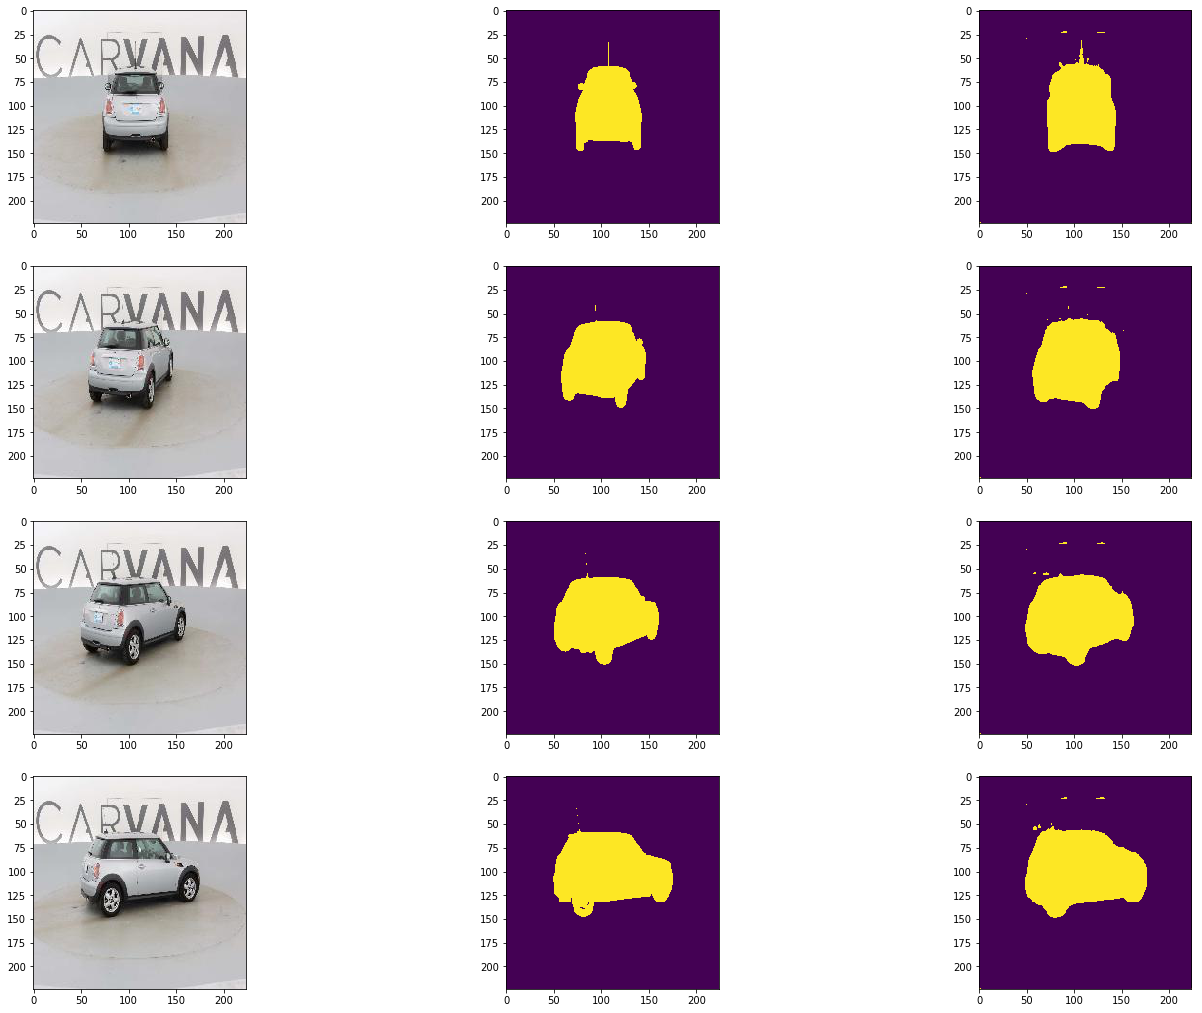

In [47]:
# Binarize the predictions
# masks_bin = np.squeeze(masks) > 0.5

# Visualize the results
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(24, 18))

for idx, img in enumerate(imgs[:4]):
    axes[idx, 0].imshow(img)

masks_true_bin = np.squeeze(masks_true)
for idx, mask in enumerate(masks_true_bin[:4]):
    axes[idx, 1].imshow(mask)

masks_pred_bin = np.squeeze(masks_pred)
for idx, mask in enumerate(masks_pred_bin[:4]):
    axes[idx, 2].imshow(mask >= 0.5)

plt.show()

In [113]:
print(masks_true_bin.dtype, masks_true_bin.shape,
      np.unique(masks_true_bin))
print(masks_pred_bin.dtype, masks_pred_bin.shape,
      np.unique(masks_pred_bin))

uint8 (10, 320, 480) [  0 255]
float32 (10, 320, 480) [ 0.00581708  0.00587963  0.00597437 ...,  0.99999726  0.99999809
  0.99999869]


14919


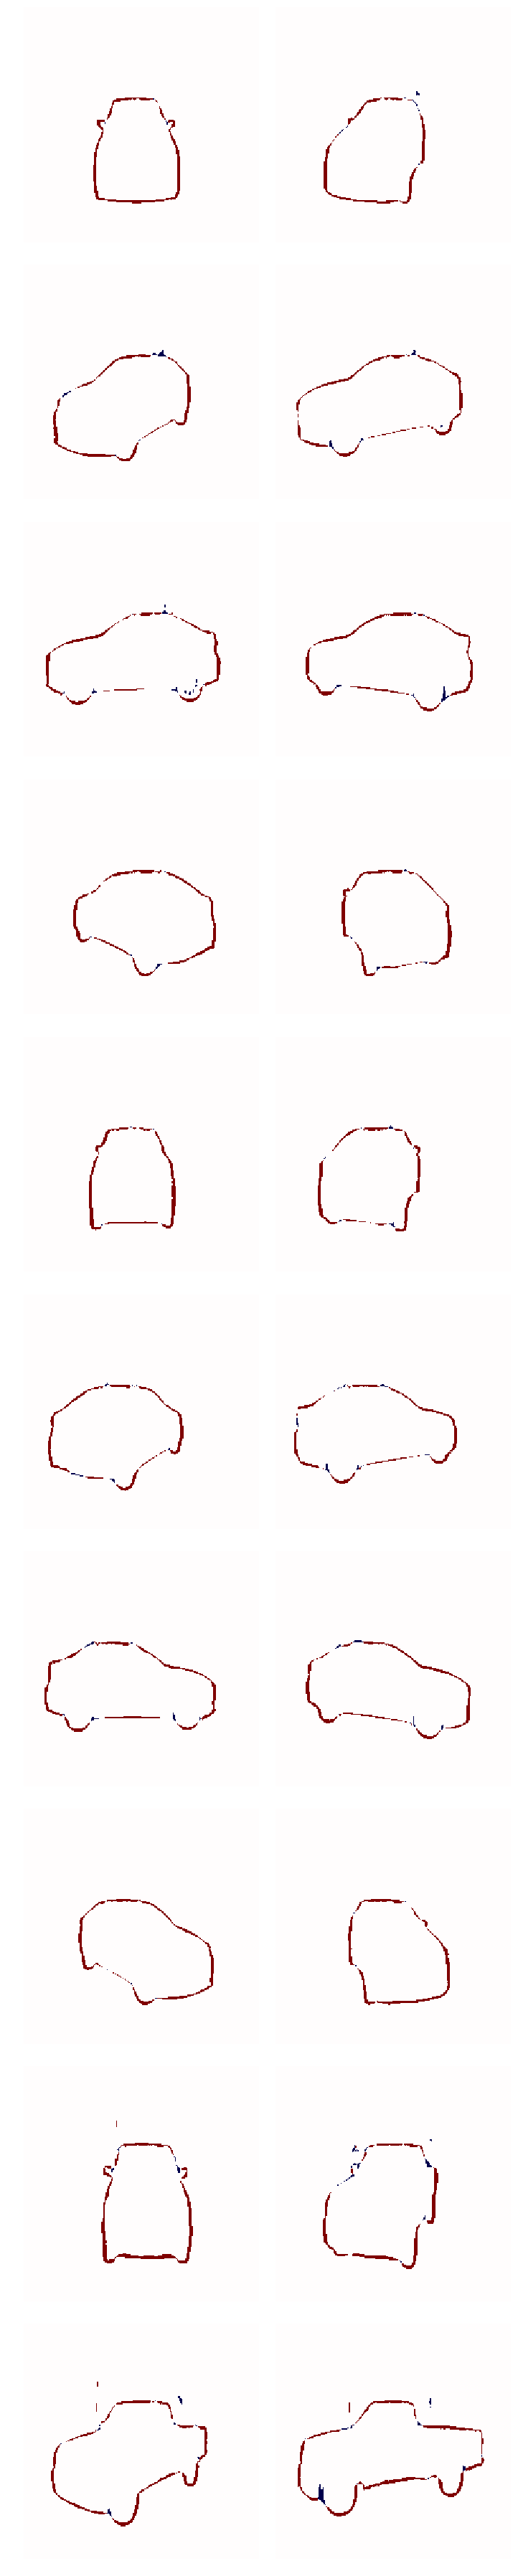

In [17]:
NCOLS = 2
NROWS = 10
fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(10, 50))
ax = axes.ravel()

miss_count = 0

for idx in range(len(ax)):
    mask_true_bin = masks_true_bin[idx] >= 127
    mask_pred_bin = masks_pred_bin[idx] >= 0.5
#     KERNEL = np.ones((7, 7))
    KERNEL = ndi.iterate_structure(
        ndi.generate_binary_structure(2, 1), 4
    )
    mask_pred_bin_modif = ndi.morphology.binary_erosion(
        mask_pred_bin, KERNEL)
#     mask_pred_bin_modif = mask_pred_bin

    tmp_true = mask_true_bin.astype(np.int8)
    # tmp_pred = mask_pred_bin.astype(np.int8)
    tmp_pred = mask_pred_bin_modif.astype(np.int8)

    ### cm.RdBu - `blue` is positive, `red` is negative
    ### cm.seismic - `red` is positive, `blue` is begative
    # ax[idx].imshow(np.bitwise_xor(mask_true_bin, mask_pred_bin))
    tmp_diff = tmp_true - tmp_pred
    miss_count += np.sum(np.abs(tmp_diff))

    # Visualize
    ax[idx].imshow(tmp_diff,
                   cmap=plt.cm.seismic)
    ax[idx].set_axis_off()

# plt.tight_layout()
print(miss_count)
fig.tight_layout()
plt.show()

(224, 224)


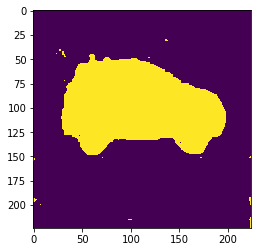

uint8
0


In [82]:
# Visualize downscaled predictions
img = cv2.imread('../data/predicts_224/13987558f6b2_13.jpg', cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow((img >= 1).astype(np.uint8))
plt.show()
print(img.dtype)
print(np.min(img))

[[False False  True False False]
 [False  True  True  True False]
 [ True  True  True  True  True]
 [False  True  True  True False]
 [False False  True False False]]


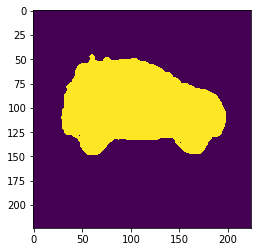

In [83]:
# Improve the prediction via morphology
struct = ndi.morphology.generate_binary_structure(2, 1)
struct = ndi.morphology.iterate_structure(struct, 2)
print(struct)

img_bin = img >= 1
img_fixed = ndi.morphology.binary_opening(img_bin, struct)
plt.imshow(img_fixed)
plt.show()

In [84]:
# Resize the prediction to the full size, and visualize them
mask_up = cv2.resize(img_fixed.astype(np.uint8), (1913, 1280))

plt.imshow(mask_up)
plt.show()
print(np.unique(mask_up))

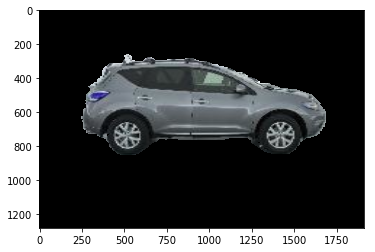

In [87]:
# Apply prediction mask to the test image
img = cv2.imread('../data/test_224/13987558f6b2_13.jpg')
img_up = cv2.resize(img, (1913, 1280))
img_up[np.where(mask_up==0)] = 0
plt.imshow(img_up)
plt.show()

|

|

|

|

|

|

|

|

|

|

|

In [18]:
# Visualize test images, and predicted improved resized 4/*.jpg'))
fnames_out_224 = sorted(glob.glob('../data/predicts_224/*.jpg'))

idxs = np.random.randint(0, len(fnames_in_224), 10)
sel_in = [fnames_in_224[i] for i in idxs]
sel_out = [fnames_out_224[i] for i in idxs]

fig, axes = plt.subplots(ncols=2, nrows=len(idxs), figsize=(10, 40))

for idx, (f_i, f_o) in enumerate(zip(sel_in, sel_out)):
    img = cv2.imread(f_i, cv2.IMREAD_COLOR)[:, :, ::-1]
    mask = cv2.imread(f_o, cv2.IMREAD_GRAYSCALE)
    
    axes[idx, 0].imshow(img)
    mask = np.not_equal(mask, 0)
    mask = ndi.filters.median_filter(mask, size=7, mode='constant', cval=False)
    mask = cv2.resize(mask.astype(np.uint8), (1918, 1280))
    mask = np.not_equal(mask, 0)
    axes[idx, 1].imshow(mask)
    
    print(np.unique(mask))
    print(np.min(mask), np.max(mask))

plt.show()

NameError: name 'fnames_in_224' is not defined

In [21]:
struct = ndi.generate_binary_structure(2, 2)
print(struct)
struct = ndi.iterate_structure(struct, 4)
print(struct)

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]]


In [22]:
y = ndi.morphology.binary_closing(x, struct)

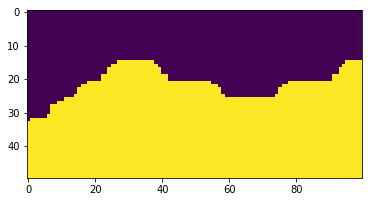

In [24]:
plt.imshow(y[425:475, 550:650])
plt.show()

RLE Debugging
---------------

                   img                                           rle_mask
0  07bcb1717ce1_07.jpg  760813 1 762730 3 764648 3 766565 5 768245 42 ...
1  094b252c77dd_08.jpg  783381 22 783593 30 785298 24 785510 32 787216...
2  0cdfe597590f_01.jpg  660625 22 662542 24 664460 24 666378 24 668281...
3  10f03351804a_11.jpg  783385 50 785302 52 787220 52 789138 52 791049...
4  145156d86628_06.jpg  707009 6 708926 7 710844 7 712761 9 714433 6 7...
5  181e00798bee_04.jpg  622737 1 624654 3 626572 3 628489 5 630405 9 6...
6  19ef6aed48cd_01.jpg  683601 2 685518 4 687436 4 689354 5 691269 10 ...
7  1cb7786e90c7_09.jpg  760469 2 762386 4 764304 4 766222 4 768137 10 ...
8  223760ab2077_15.jpg  852409 14 854326 16 856244 16 858162 17 860045...
9  257d8c06c4ba_08.jpg  883297 6 885214 8 887132 8 889050 8 890765 14 ...


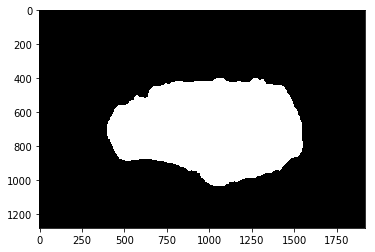

760813 1 7
760813 1 7


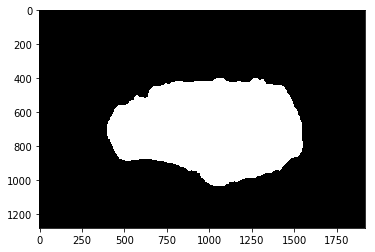

In [2]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
import scipy.ndimage as ndi

from utils import _rle_string_to_mask, _mask_to_rle_string


# df_masks = pd.read_csv('../data/train_masks.csv', nrows=10)
df_masks = pd.read_csv('./temp_submission.csv', nrows=10)
print(df_masks)

# Check mask recovery from code on train example
temp_rle = df_masks['rle_mask'][0]
temp_mask = _rle_string_to_mask(temp_rle)
plt.imshow(temp_mask, cmap=plt.cm.gray)
plt.show()

# Check if encoding is correct via roundtrip
temp_rle_recov = _mask_to_rle_string(temp_mask)
temp_mask_recov = _rle_string_to_mask(temp_rle_recov)
temp_mask_recov = _rle_string_to_mask(_mask_to_rle_string(temp_mask_recov))
print(temp_rle[:10])
print(temp_rle_recov[:10])
plt.imshow(temp_mask_recov, cmap=plt.cm.gray)
plt.show()

In [3]:
import imageio

In [6]:
temp = imageio.imread('../data/test_320_480/19ef6aed48cd_01.jpg')
# temp = imageio.imread('../data/predicts_320_480_deep/19ef6aed48cd_01.jpg')

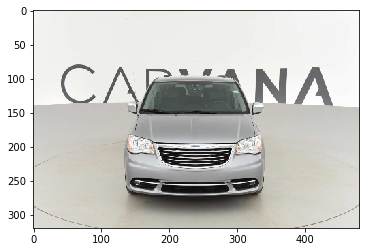

In [7]:
plt.imshow(temp)
plt.show()

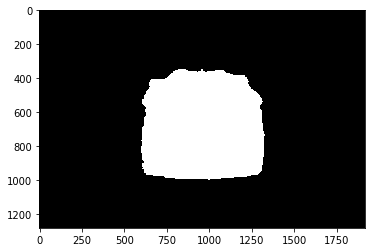

660625 22 
660625 22 


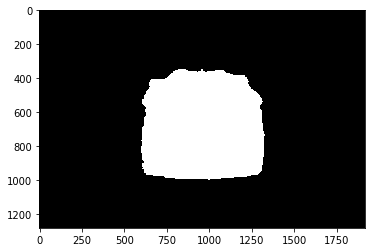

IndexError: boolean index did not match indexed array along dimension 0; dimension is 320 but corresponding boolean dimension is 1280

In [9]:
# Check mask recovery from code on train example
temp_rle = df_masks['rle_mask'][2]
temp_mask = _rle_string_to_mask(temp_rle)
plt.imshow(temp_mask, cmap=plt.cm.gray)
plt.show()

# Check if encoding is correct via roundtrip
temp_rle_recov = _mask_to_rle_string(temp_mask)
temp_mask_recov = _rle_string_to_mask(temp_rle_recov)
temp_mask_recov = _rle_string_to_mask(_mask_to_rle_string(temp_mask_recov))
print(temp_rle[:10])
print(temp_rle_recov[:10])
plt.imshow(temp_mask_recov, cmap=plt.cm.gray)
plt.show()

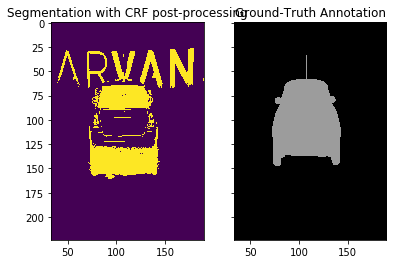

In [86]:
# CRF 
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import (compute_unary,
                              create_pairwise_bilateral,
                              create_pairwise_gaussian,
                              unary_from_softmax,
                              unary_from_labels)

image = imgs[0]

# `final_probabilities` is a pixel wise softmax output of the DNN
# `processed_probabilities` is who knows what
# softmax = final_probabilities.squeeze()
# softmax = processed_probabilities.transpose((2, 0, 1))
# masks_pred_bin[0]
softmax = masks_pred[0]
softmax_prep = np.dstack((1-softmax, softmax)).transpose((2, 0, 1))

# The input should be the negative of the logarithm of probability values
unary = unary_from_softmax(softmax_prep)
unary = np.ascontiguousarray(unary)

d = dcrf.DenseCRF2D(image.shape[0], image.shape[1], 2)

d.setUnaryEnergy(unary)

# This potential penalizes small pieces of segmentation that are
# spatially isolated -- enforces more spatially consistent segmentations
feats = create_pairwise_gaussian(sdims=(10, 10), shape=image.shape[:2])

d.addPairwiseEnergy(feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

# This creates the color-dependent features --
# because the segmentation that we get from CNN are too coarse
# and we can use local color features to refine them
feats = create_pairwise_bilateral(sdims=(70, 70), schan=(20, 20, 20),
                                  img=image, chdim=2)

d.addPairwiseEnergy(feats, compat=10,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(40)

res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

cmap = plt.get_cmap('bwr')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(res)
# ax1.imshow(res, vmax=1.5, vmin=-0.4, cmap=cmap)
ax1.set_title('Segmentation with CRF post-processing')

# `train_annotation` is a ground truth segmentation mask
probability_graph = ax2.imshow(np.dstack((masks_true_bin[0],)*3)*100)
ax2.set_title('Ground-Truth Annotation')
plt.show()